In [52]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(font_scale=1.2)
sns.set_style("white")

In [53]:
# define column names
# cpu_col = 'CPU time [%]'
cpu_col = 'Resource req. [e.g., CPU time]'
# thr_col = 'Max. throughput [Gbit/s]'
thr_col = 'Traffic load [e.g., Mbit/s]'

In [54]:
# generate synthetic data
def gen_benchmark(cpu, coeff1=1, coeff2=1):
    """Generate max throughput for given CPU time according to log function"""
    return coeff1 * math.log2(1 + coeff2 * cpu)

def synthetic_benchmark():
    """Generate synthetic benchmark results for CPU time 0-100%"""
    cpu_list = np.arange(0.1, 1, .01)
    data = []
    for cpu in cpu_list:
        data.append([cpu, gen_benchmark(cpu, coeff2=100)])
    return pd.DataFrame(data, columns=[cpu_col, thr_col])

# inverse function to calculate cpu given a throughput
def inverse(thru, coeff2=1):
    return (1/coeff2) * (2**thru - 1)

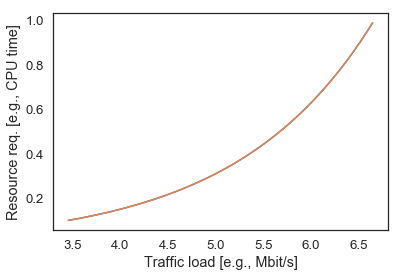

In [55]:
df = synthetic_benchmark()
# sns.lineplot(df[cpu_col], df[thr_col])
sns.lineplot(df[thr_col], df[cpu_col])

cpu = [inverse(thr, coeff2=100) for thr in df[thr_col]]
sns.lineplot(df[thr_col], cpu)

In [56]:
# process data
# no need for validation or test split in this simple example
X = df[[thr_col]]
y = df[cpu_col]
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(X)
# X_scaled = scaler.transform(X)

In [57]:
# train linear model
lin_reg = LinearRegression()
lin_reg.fit(X, y)
# predict
lin_col = 'Linear'
df[lin_col] = lin_reg.predict(X)

# save trained model
joblib.dump(lin_reg, 'ml_models/synth_data/linear.joblib')
# test loading and predicting. shouldn't change anything
# new = joblib.load('ml_models/lin_reg_syn.joblib')
# df[lin_col] = new.predict(X)

['ml_models/synth_data/linear.joblib']

In [58]:
# train gradient boosting
boost = GradientBoostingRegressor()
boost.fit(X, y)
boost_col = 'Boosting'
df[boost_col] = boost.predict(X)
joblib.dump(boost, 'ml_models/synth_data/boosting.joblib')

# nice fit
mean_squared_error(df[cpu_col], df[boost_col])

1.3973775364044988e-07

In [59]:
boost.predict([[10.0]])

array([0.98981099])

In [60]:
inverse(10, coeff2=100)

10.23

In [61]:
# plotting for cpu 0-100
def plot_cpu_0_100():
    fig, ax = plt.subplots()

    fixed = 80

    # lines
    plt.plot(df[thr_col], df[cpu_col], label='True', color='black', linewidth=2)
    plt.plot(df[thr_col], df[lin_col], color='blue', linewidth=2)
    plt.axhline(y=fixed, label='Fixed', color='green', linewidth=2)

    # fill in between
    ax.fill_between(df[thr_col], df[cpu_col], fixed, where=df[cpu_col]<fixed, facecolor='white', edgecolor='grey', hatch='//')
    ax.fill_between(df[thr_col], df[lin_col], df[cpu_col], where=df[lin_col]<df[cpu_col], facecolor='lightgrey', edgecolor='grey', hatch='\\')

    # # text
    ax.text(10.5, 60, 'Over-allocation', bbox={'facecolor': 'white'})
    ax.annotate('Under-allocation', xy=(10.2, 5), xytext=(11, 5), arrowprops={'facecolor': 'black'}, verticalalignment='center')

    plt.xlabel(thr_col)
    plt.ylabel(cpu_col)
    plt.xlim(10)
    #plt.ylim(0, 1)
    plt.legend()

    fig.savefig('plots/example_alloc.pdf', bbox_inches='tight')
    
# plot_cpu_0_100()

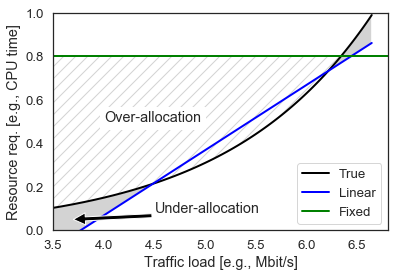

In [62]:
# plotting for cpu 0-1
fig, ax = plt.subplots()

fixed = 0.8

# lines
plt.plot(df[thr_col], df[cpu_col], label='True', color='black', linewidth=2)
plt.plot(df[thr_col], df[lin_col], color='blue', linewidth=2)
# plt.plot(df[thr_col], df[boost_col], color='red', linewidth=2)
plt.axhline(y=fixed, label='Fixed', color='green', linewidth=2)

# fill in between
ax.fill_between(df[thr_col], df[cpu_col], fixed, where=df[cpu_col]<fixed, facecolor='white', edgecolor='lightgrey', hatch='//')
ax.fill_between(df[thr_col], df[lin_col], df[cpu_col], where=df[lin_col]<df[cpu_col], facecolor='lightgrey')

# # text
ax.text(4, 0.5, 'Over-allocation', bbox={'facecolor': 'white'})
ax.annotate('Under-allocation', xy=(3.7, 0.05), xytext=(4.5, 0.1), arrowprops={'facecolor': 'black'}, verticalalignment='center')

plt.xlabel(thr_col)
plt.ylabel(cpu_col)
plt.xlim(3.5)
plt.ylim(0, 1)
plt.legend()

fig.savefig('plots/example_alloc.pdf', bbox_inches='tight')
# for presentation as png
fig.savefig('plots/example_alloc_lin.png', bbox_inches='tight')

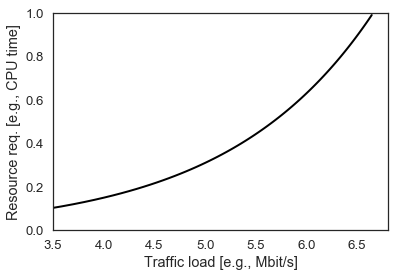

In [63]:
# split into parts for presentation; save as png
# first: only true requirements

fig, ax = plt.subplots()

# lines
plt.plot(df[thr_col], df[cpu_col], label='True', color='black', linewidth=2)

plt.xlabel(thr_col)
plt.ylabel(cpu_col)
plt.xlim(3.5)
plt.ylim(0, 1)

fig.savefig('plots/example_alloc_true.png', bbox_inches='tight')

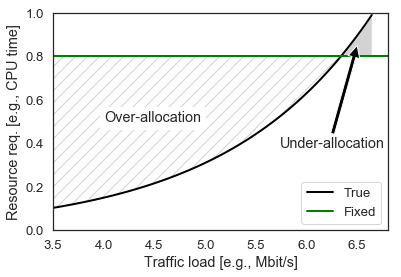

In [64]:
# 2nd: plot fixed resource alloc at 80%
fig, ax = plt.subplots()

fixed=0.8

# lines
plt.plot(df[thr_col], df[cpu_col], label='True', color='black', linewidth=2)
plt.axhline(y=fixed, label='Fixed', color='green', linewidth=2)

# fill in between
ax.fill_between(df[thr_col], df[cpu_col], fixed, where=df[cpu_col]<fixed, facecolor='white', edgecolor='lightgrey', hatch='//')
ax.fill_between(df[thr_col], df[cpu_col], fixed, where=df[cpu_col]>fixed, facecolor='lightgrey')

# # text
ax.text(4, 0.5, 'Over-allocation', bbox={'facecolor': 'white'})
ax.annotate('Under-allocation', xy=(6.5, 0.85), xytext=(6.25, 0.4), arrowprops={'facecolor': 'black'}, verticalalignment='center', horizontalalignment='center')

plt.xlabel(thr_col)
plt.ylabel(cpu_col)
plt.xlim(3.5)
plt.ylim(0, 1)
plt.legend()

fig.savefig('plots/example_alloc_fixed.png', bbox_inches='tight')